In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm #to show the progress in the function for best score calculation within range
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict 

import hdbscan
import folium
import re

cols = ['#e9194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f03e26', '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
        '#000075','#808000'] * 10  #introducing more colors to differentiate  

In [2]:
df = pd.read_csv("taxi_data.csv")
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [3]:
df.duplicated(subset=['LON', 'LAT']).values.any() #checking whether duplicate value exists
df.isna().values.any() #checking whether there is null value

True

In [4]:
df.dropna(inplace=True) #null value removal
df.drop_duplicates(subset=['LON', 'LAT'], keep = 'first', inplace=True) #duplicate removal

In [5]:
X = np.array(df[['LON', 'LAT']], dtype = 'float64')

In [6]:
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

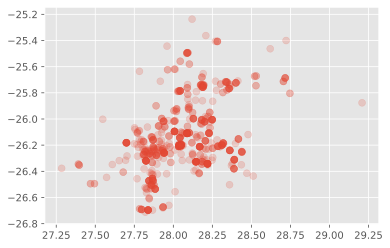

In [7]:
plt.scatter(X[:, 0], X[:, 1], alpha = 0.2, s = 50)

# Performance Metric 

# K means

In [8]:
X = np.array(df[['LON', 'LAT']], dtype = 'float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_KMeans{k}'] = class_predictions #new column in dataframe showing the predicted clusters for k-means

create_map() functions shows the interactive map of clusters with different colors

In [9]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start = 9, tiles = 'Stamen Toner')

    for _, row in df.iterrows(): #return touple of the row number and information in the rows
        if row[cluster_column] == -1:
            cluster_color = '#000000' #to mark the outliers point as black to identify
        else:
            cluster_color = cols[row[cluster_column]]
        
        folium.CircleMarker(
            location = [row['LAT'], row['LON']],
            radius = 5,
            popup = row[cluster_column],
            color = cluster_color,
            fill = True,
            fill_color = cluster_color
        ).add_to(m)
    return m
    
m = create_map(df, 'CLUSTER_KMeans70')
print(f'K = {k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('Kmeans70.html') # for saving the result into a html page

K = 70
Silhouette Score: 0.6367300948961482


In [10]:
m

In [11]:
# this code snippet explores the best silhouette score within given range of cluster size, in this case from 2 to 100
best_silhouette, best_k = -1, 0
for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')

100%|██████████| 98/98 [00:16<00:00,  5.82it/s]

K=98
Silhouette Score: 0.6971995093340411


# DBSCAN

In [12]:
model = DBSCAN(eps = 0.01, min_samples=5).fit(X) #radius,eps I will consider to make a potential cluster, hyperparameter
class_predictions = model.labels_ #how many samples need to be in the cluster

df['CLUSTERS_DBSCAN'] = class_predictions

In [13]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')  #how many clusters dbscan found
print(f'Number of outliers found: {len(class_predictions[class_predictions == -1])}')  #number of -1's which has been considered as 

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions != -1], class_predictions[class_predictions != -1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(class_predictions)]) #modifying all -1's to some other values so that same noise values don't repeat too often
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}') #which suggests we might make some improvements

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [14]:
m

# HDBSCAN

In [15]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [17]:
df.tail()

,LON,LAT,NAME,CLUSTER_KMeans70,CLUSTERS_DBSCAN,CLUSTER_HDBSCAN
832,28.04441,-26.19727,Zimbabwe Taxi Rank,7,9,53
833,27.82999,-26.24445,Zola Clinic Taxi Rank,1,25,63
834,27.83991,-26.24235,Zola Taxi Rank,1,-1,63
835,27.86166,-26.23624,Zondi Taxi Rank,49,-1,65
836,28.39097,-26.30931,kwaThema Taxi Rank,10,19,14


In [18]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')  #how many clusters dbscan found
print(f'Number of outliers found: {len(class_predictions[class_predictions == -1])}')  #number of -1's

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions != -1], class_predictions[class_predictions != -1])}')
no_outliers = 0
no_outliers = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}') #which suggests we might make some improvements

Number of clusters found: 67
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.638992483305273


# outlier addressing

In [19]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [20]:
df_train = df[df.CLUSTER_HDBSCAN != -1]
df_predict = df[df.CLUSTER_HDBSCAN == -1]

In [21]:
X_train = np.array(df_train[['LON', 'LAT']], dtype = 'float64')
Y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype = 'float64') #outlier labels

In [22]:
classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [23]:
predictions = classifier.predict(X_predict)

In [24]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [25]:
df.loc[df.CLUSTER_HDBSCAN == -1, 'CLUSTER_hybrid'] = predictions

In [26]:
m = create_map(df, 'CLUSTER_hybrid')

In [27]:
m

In [28]:
class_predictions = df['CLUSTER_hybrid']
print(f'Number of clusters found: {len(np.unique(class_predictions))}')  #how many clusters hybrid hdbscan found
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('hrbrid.html')


Number of clusters found: 66
Silhouette Score: 0.5849126494706486


Text(0.5, 0, 'Cluster sizes')

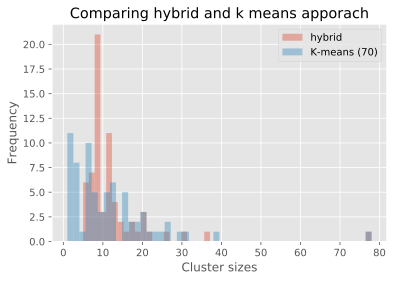

In [29]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins = 50, alpha = 0.4, label = 'hybrid')
df['CLUSTER_KMeans70'].value_counts().plot.hist(bins = 50, alpha = 0.4, label = 'K-means (70)')

plt.legend()
plt.title('Comparing hybrid and k means apporach')
plt.xlabel('Cluster sizes')